<a href="https://colab.research.google.com/github/ekomissarov/data-analysis/blob/main/13_confidence_intervals_exact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title impotring libraries
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import auth
import gspread
from google.auth import default

plt.style.use('dark_background')


(-1.959963984540054, 1.959963984540054)

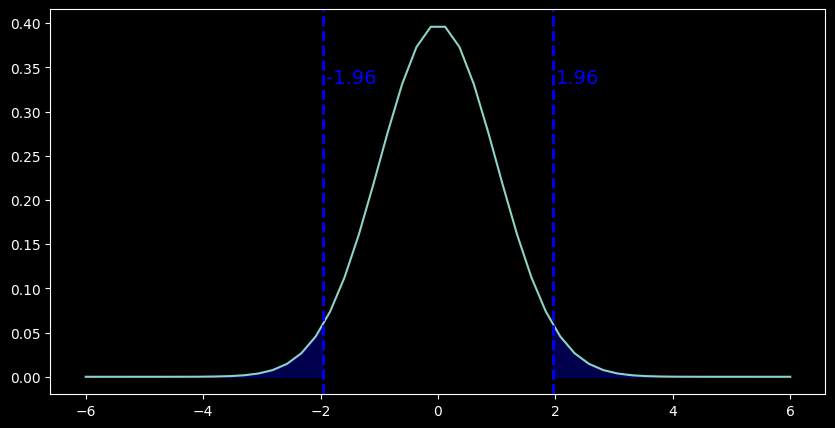

In [2]:
def norm_conf_int(alpha, mean_hat=0, std_hat=1, margin=6):
    """
        Constructs a (1-alpha)*100% asymptotically normal confidence interval
    """

    plt.figure(figsize=(10,5))
    xs = np.linspace(mean_hat - margin, mean_hat + margin)
    pdf = sts.norm(mean_hat, std_hat).pdf(xs)

    plt.plot(xs, pdf)
    plt.ylabel('', fontsize=18)
    plt.xlabel('', fontsize=18)

    left, right = sts.norm.interval(1 - alpha, loc=mean_hat, scale=std_hat)

    for i in [left, right]:
        y_max = plt.ylim()[1]
        plt.axvline(i, color="blue", linestyle='dashed', lw=2)

        if i == left:
            xq = np.linspace(mean_hat - margin, left)
        else:
            xq = np.linspace(right, mean_hat + margin)

        text_margin = 0.05
        plt.text(i + text_margin, 0.8*y_max, round(i, 2), color="blue", fontsize=14)
        yq = sts.norm(mean_hat, std_hat).pdf(xq)
        plt.fill_between(xq, 0, yq, color='blue', alpha=0.3)

    return left, right

norm_conf_int(alpha=0.05)

In [3]:
#@title google spreadsheet urls

#paste here:
url = "https://docs.google.com/spreadsheets/d/1nj7yEFnMiJekUKxxZj8XOKtX6VYUcB-gOJ2GIZWiyc0/edit?usp=sharing"
doc_id = url.split('/')[-2]
display(doc_id)


'1nj7yEFnMiJekUKxxZj8XOKtX6VYUcB-gOJ2GIZWiyc0'

In [4]:
#@title user authenticate & read dfs
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

worksheet = gc.open_by_key(doc_id).worksheet('flat')  # open sheet by list name
rows = worksheet.get_all_values()  # get_all_values gives a list of rows
df_copy = pd.DataFrame.from_records(rows[1:], columns=rows[0])  # Convert to a DataFrame and render




Описание переменных:

n – номер квартиры по порядку

price – цена квартиры в $1000

totsp – общая площадь квартиры, кв.м.

livesp жилая площадь квартиры, кв.м.

kitsp – площадь кухни, кв.м.

dist – расстояние от центра в км.

metrdist – расстояние до метро в минутах

walk – 1 – пешком от метро, 0 – на транспорте

brick 1 – кирпичный, монолит ж/б, 0 – другой

floor 1 – этаж кроме первого и последнего, 0 – иначе.

code – число от 1 до 8 кодирует район


In [5]:
#@title preparening data
df = df_copy.copy()
df.drop(columns=['n'], inplace=True)
for i in df.columns:
    if i =='dist' or i == 'kitsp':
        continue
    df[i] = df[i].astype('int')
df['dist'] = df.dist.astype('float')
df['kitsp'] = df.kitsp.astype('float')
df['code'] = df.code.map(lambda x: f"district {x}")
df

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,81,58,40,6.0,12.5,7,1,1,1,district 3
1,75,44,28,6.0,13.5,7,1,0,1,district 6
2,128,70,42,6.0,14.5,3,1,1,1,district 3
3,95,61,37,6.0,13.5,7,1,0,1,district 1
4,330,104,60,11.0,10.5,7,0,1,1,district 3
...,...,...,...,...,...,...,...,...,...,...
2035,110,77,45,10.0,12.0,5,0,0,1,district 5
2036,95,60,43,6.0,9.0,5,0,0,1,district 4
2037,95,60,46,5.0,10.5,5,1,0,1,district 7
2038,129,76,48,10.0,12.5,5,0,0,1,district 3


In [6]:
#manually
norm_rv = sts.norm()

alpha = 0.05
z_crit = norm_rv.ppf(1 - alpha/2)

mu_hat = df.price.mean()
var_hat = df.price.var(ddof=1)
n = df.price.count()

left = mu_hat - z_crit*np.sqrt(var_hat/n)
right = mu_hat + z_crit*np.sqrt(var_hat/n)

print("condidens interval [{:.4}; {:.4}] width {:.4}".format(left, right, right - left))

condidens interval [125.2; 129.7] width 4.502


In [7]:
mu_hat = df.price.mean()
sd_hat = df.price.std(ddof=1)/np.sqrt(n)

sts.norm.interval(0.95, loc=mu_hat, scale=sd_hat)


(125.24534794254012, 129.74778931236185)

(125.24534794254012, 129.74778931236185)

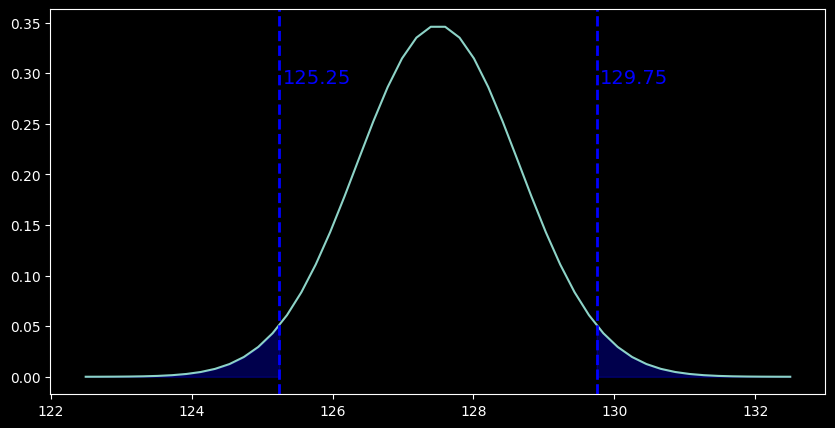

In [8]:
alpha = 0.05
mu_hat = df.price.mean()
sd_hat = df.price.std(ddof=1)/np.sqrt(n)

norm_conf_int(alpha, mu_hat, sd_hat, margin=5)

In [9]:
# manually exact interval
n = df.price.count()
t_rv = sts.t(n - 1)

alpha = 0.05
t_crit = t_rv.ppf(1 - alpha/2)

mu_hat = df.price.mean()  #  df.price MUST be normal distributed for small samples
var_hat = df.price.var(ddof=1)


left = mu_hat - t_crit*np.sqrt(var_hat/n)
right = mu_hat + t_crit*np.sqrt(var_hat/n)


print("condidens interval [{:.4}; {:.4}] width {:.4}".format(left, right, right - left))

condidens interval [125.2; 129.7] width 4.505


In [10]:
alpha = 0.05
n = df.price.count()
n = df.price.count()
mu_hat = df.price.mean()  #  df.price MUST be normal distributed for small samples
sd_hat = df.price.std(ddof=1) / np.sqrt(n)

left, right = sts.t.interval(1-alpha, df=(n-1), loc=mu_hat, scale=sd_hat)


print("condidens interval [{:.4}; {:.4}] width {:.4}".format(left, right, right - left))

condidens interval [125.2; 129.7] width 4.505


In [11]:

alpha = 0.01
df_agg = df.groupby('code')['price'].agg(['mean', 'std', 'count'])  #  df.price MUST be normal distributed for small samples
df_agg['t_crit'] = df_agg['count'].apply(lambda w: sts.t(w - 1).ppf(1 - alpha/2))

df_agg['step'] =  df_agg['t_crit']  * df_agg['std']/np.sqrt(df_agg['count'])
#df_agg['left'] = df_agg['mean'] - df_agg['step']
#df_agg['right'] = df_agg['mean'] + df_agg['step']
df_agg



,mean,std,count,t_crit,step
code,,,,,
district 1,134.411765,49.619507,272,2.594092,7.804650
district 2,110.316279,29.518448,215,2.598998,5.232150
district 3,148.246377,70.573565,345,2.590197,9.841589
district 4,148.693780,73.656832,209,2.599672,13.245198
district 5,115.779762,31.507483,336,2.590585,4.452889
district 6,109.964981,32.976595,257,2.595170,5.338326
district 7,114.230088,33.897495,226,2.597856,5.857718
district 8,136.744444,48.639263,180,2.603574,9.438884


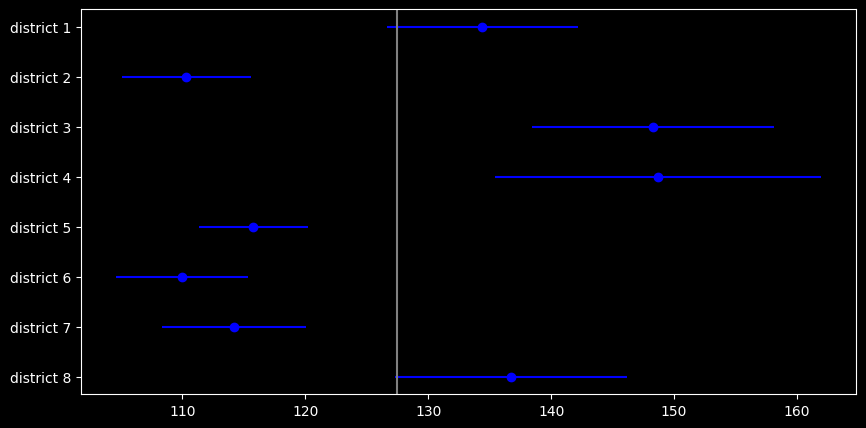

In [12]:
def plot_simple_intervals(centers, step, labels, mu_hat):
    plt.figure(figsize=(10,5))
    plt.errorbar(centers,  #x
                 np.arange(centers.size-1, -1, -1),  #y
                 xerr = step,
                 yerr = 0,
                 capsize=0,
                 fmt="o", color="blue"
    )
    plt.yticks(
        np.arange(centers.size-1, -1, -1),
        labels
    );
    plt.axvline(mu_hat, 0, color='grey');


plot_simple_intervals(centers = df_agg['mean'],
                      step = df_agg['step'],
                      labels = df_agg.index,
                      mu_hat = df.price.mean())

In [15]:
#confidence interval for the difference in means.
#Monolithic and panel houses

alpha = 0.05
x = df[df.brick == 1].price.values  #monolithic
y = df[df.brick == 0].price.values  #panel

diff = x.mean() - y.mean()
nx, ny = x.size, y.size
diff_sd = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/nx)

left, right = sts.norm.interval(1-alpha, loc=diff, scale=diff_sd)
print("Confidence interval [{:.4}; {:.4}] width {:.4}".format(left, right, right - left))
# zero is outside the confidence interval

Confidence interval [23.04; 34.81] width 11.77


In [17]:
#assume that the variances are unknown but equal

alpha = 0.05
diff = x.mean() - y.mean()
nx, ny = x.size, y.size

s2 = ((nx - 1)*x.var() + (ny - 1)*y.var())/(nx + ny - 2)
diff_sd = np.sqrt(s2/nx + s2/ny)

left, right = sts.t.interval(1-alpha, df=(nx + ny - 2), loc=diff, scale=diff_sd)
print("Confidence interval [{:.4}; {:.4}] width {:.4}".format(left, right, right - left))


Confidence interval [24.28; 33.58] width 9.297


In [21]:
#BUT in reality the variances are very different in this case
#and here the sample does not have a normal distribution, the use of student's criteria is not correct
x.var(), y.var()

(4264.981392232218, 1668.1298841576563)

In [23]:
#assume that the variances are unknown and not equal

alpha = 0.05
diff = x.mean() - y.mean()
nx, ny = x.size, y.size
diff_sd = np.sqrt(x.var()/nx + y.var()/ny)

u = (x.var() / nx + y.var() / ny) ** 2
d = (x.var()**2) / (nx**2 * (nx - 1)) + (y.var()**2)/ (ny**2* (ny - 1))
nu =  u/d
print("number of degrees of freedom:", nu)

left, right = sts.t.interval(1-alpha, df=nu, loc=diff, scale=diff_sd)
print("Confidence interval [{:.4}; {:.4}] width {:.4}".format(left, right, right - left))

number of degrees of freedom: 911.4012642833161
Confidence interval [23.49; 34.37] width 10.88


In [25]:
print(nx, ny)
print(x.std(), y.std())
# Comparison signs in the wrong direction => with small samples we don't really believe it

659 1381
65.30682500498871 40.842745796012004
